<a href="https://colab.research.google.com/github/muthuv11/NLP_lily/blob/master/NLP_caseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
To predict the sentiment from the provided twitter tweet dataset.

6+1 features provided.

tweet_id, name, text, tweet_created, tweet_location, user_timezone - sentiment

# Assumptions

Supervised model

# Dependencies

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import numpy as np
import re
import spacy
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize




!pip install contractions
!pip install textsearch

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Data Loading

In [0]:
df = pd.read_csv('/content/Data.csv')

In [53]:
df.head()

,tweet_id,sentiment,name,text,tweet_created,tweet_location,user_timezone
0,1,neutral,cairdin,What @dhepburn said.,24/02/15 11:35,NaN,Eastern Time (US & Canada)
1,2,positive,jnardino,plus you've added commercials to the experienc...,24/02/15 11:15,NaN,Pacific Time (US & Canada)
2,3,neutral,yvonnalynn,I didn't today... Must mean I need to take ano...,24/02/15 11:15,Lets Play,Central Time (US & Canada)
3,4,negative,jnardino,"it's really aggressive to blast obnoxious ""ent...",24/02/15 11:15,NaN,Pacific Time (US & Canada)
4,5,negative,jnardino,and it's a really big bad thing about it,24/02/15 11:14,NaN,Pacific Time (US & Canada)


# Data Descriptive Analysis

Data shape & % of Missing values

In [54]:
print("Dataset shape",df.shape)
print("% of Null values \n", (df.isna().sum()/len(df))*100)

Dataset shape (14640, 7)
% of Null values 
 tweet_id           0.000000
sentiment          0.000000
name               0.000000
text               0.000000
tweet_created      0.000000
tweet_location    32.329235
user_timezone     32.923497
dtype: float64


Check for duplicate data

In [55]:
def chk_duplicate_clean():
    dup = df[df.duplicated()].copy()
    print('duplicate observations- ', dup.shape[0])
    df.drop_duplicates(keep='first',inplace=True) 
    if dup.shape[0] >0 :
          return dup

chk_duplicate_clean()

duplicate observations-  0


Check for class balance

negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64


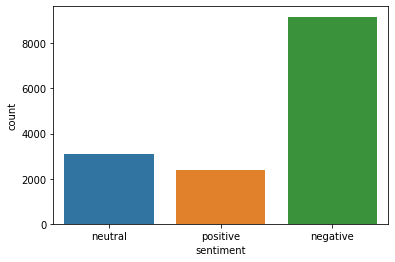

In [56]:
def chk_classBalance(target_col):
    print(df[target_col].value_counts())
    sns.countplot(df[target_col])

chk_classBalance('sentiment')

In [57]:
df.dtypes

tweet_id           int64
sentiment         object
name              object
text              object
tweet_created     object
tweet_location    object
user_timezone     object
dtype: object

# Data pre-Processing

In [0]:
# remove accented character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
  
# Remove special charcters
def remove_special_characters(text):
      # remove special characters, numbers, punctuations
      pattern = r'[^a-zA-Z#\s]'
      text = re.sub(pattern, '', text)
      return text

# function to collect hashtags
def extract_hashtags(text):
    tags = (re.findall(r"#(\w+)", text))
    return len(tags)

# Remove special charcters
def replace_tags(text):
      text = re.sub('#', '', text)
      return text
  
# Expand contractions
def expand_contractions(text):
  text = contractions.fix(text)
  return text

# no of bold words
def extract_bolds(text):
    tags = (re.findall(r"(A-Z+)", text))
    return tags

# Remove stop words and word size <3
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if (token not in stopwords and len(token) >=3)]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Remove urls
def remove_urls(text):
    no_urlText = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return no_urlText 

# Lower casing of tweets
def covert_lowerCase(text):
  text = text.lower()
  return text

# Lemmatize text
def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    wl= WordNetLemmatizer()
    text = ' '.join([wl.lemmatize(word, pos="v") for word in word_tokens])
    return text


In [214]:
#remove_accented_chars('Sómě Áccěntěd těxt')
#remove_special_characters('hshs #jsj k12 13 #@ !$')
#extract_hashtags ('hshs #jsj k12 13 @ !$')
#replace_tags('hshs #jsj k12 13 #@ !$')
#remove_contractions('''plus you've added commercials to the experience... tacky.''')
#re.findall(r"#(\w+)", 'sjdadnsd @sd ksksk')
#extract_bolds('sjda AS a')
#remove_stopwords ('Hi hello are you a friend of mr.jja can you please help yourself in finding a seat in room 23')
spacy_lemmatize_text('Hi running changing taken harder')
lemmatize_text ('Hi running changing taken harder')



hi run change take harder
Hi run change take harder


In [0]:
df = pd.read_csv('/content/Data.csv')
df['tidy_text'] = np.vectorize(remove_accented_chars)(df['text'])
df['tidy_text'] = np.vectorize(remove_special_characters)(df['tidy_text'])
df['no_tags'] = np.vectorize(extract_hashtags)(df['text'])
df['tidy_text'] = np.vectorize(replace_tags)(df['tidy_text'])
df['tidy_text'] = np.vectorize(remove_contractions)(df['tidy_text'])
df['tidy_text'] = df.tidy_text.apply(remove_stopwords)
df['tidy_text'] = df.tidy_text.apply(remove_urls)
df['tidy_text'] = df.tidy_text.apply(covert_lowerCase)
df['lemma_text'] = df.tidy_text.apply(lemmatize_text)

In [216]:
df.head()

,tweet_id,sentiment,name,text,tweet_created,tweet_location,user_timezone,tidy_text,no_tags,lemma_text
0,1,neutral,cairdin,What @dhepburn said.,24/02/15 11:35,NaN,Eastern Time (US & Canada),what dhepburn said,0,None
1,2,positive,jnardino,plus you've added commercials to the experienc...,24/02/15 11:15,NaN,Pacific Time (US & Canada),plus added commercials experience tacky,0,None
2,3,neutral,yvonnalynn,I didn't today... Must mean I need to take ano...,24/02/15 11:15,Lets Play,Central Time (US & Canada),today must mean need take another trip,0,None
3,4,negative,jnardino,"it's really aggressive to blast obnoxious ""ent...",24/02/15 11:15,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...,0,None
4,5,negative,jnardino,and it's a really big bad thing about it,24/02/15 11:14,NaN,Pacific Time (US & Canada),really big bad thing,0,None


'are not'

In [0]:
#data processing

In [0]:
#data visualization

In [0]:
#model building

In [0]:
#model Evaluation

In [0]:
#model efficacy

In [0]:
#model optimization

In [0]:
#visalization & summarization